In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from rna_motif_library.settings import DATA_PATH
from rna_motif_library.util import add_motif_indentifier_columns
from rna_motif_library.plotting import (
    publication_style_ax,
    calculate_subplot_coordinates,
    merge_sequential_coords,
)

PLOT_PATH = "../../figures/plots"

In [2]:
def rename_motif_types(df):
    """Rename motif type values to more readable format.

    Args:
        df: DataFrame containing motif data

    Returns:
        DataFrame with renamed motif types
    """
    type_mapping = {
        "HELIX": "Helix",
        "SSTRAND": "Single Strand",
        "TWOWAY": "Two-way",
        "NWAY": "N-way",
        "HAIRPIN": "Hairpin",
    }

    df["motif_type"] = df["motif_type"].map(type_mapping)
    return df

In [3]:
path = "../../data/summaries/motifs/non_redundant_motifs_summary.json"
df = pd.read_json(path)
df = df.query("motif_type != 'UNKNOWN'")
df = df.query("is_isolatable == True")
df = rename_motif_types(df)

In [4]:
df["motif_type"].value_counts()

Helix            8141
Hairpin          5395
Two-way          3007
Single Strand    2217
N-way              44
Name: motif_type, dtype: int64

In [43]:
df.iloc[0]

pdb_id                                                                           8P18
motif_id                                                     HAIRPIN-5-CCUUGAG-8P18-1
motif_sequence                                                                CCUUGAG
motif_topology                                                                      5
motif_type                                                                    Hairpin
residues                            [2-C-840-, 2-C-841-, 2-U-842-, 2-U-843-, 2-G-8...
num_non_canonical_basepairs                                                         1
num_strands                                                                         1
num_residues                                                                        7
non_canonical_bps                           [[2-G-844-, 2-G-846-, tWS, 1.6276054813]]
num_hbonds                                                                         17
num_protein_hbonds                                    

## Figure a: Motif type distribution

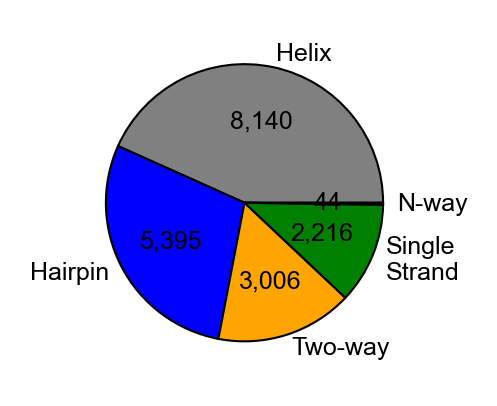

In [44]:
def figure_a(df, ax):
    """Plot pie chart of motif type counts.

    Args:
        df: DataFrame containing motif data
        ax: matplotlib axis to plot on
    """
    colors = {
        "Helix": "gray",
        "N-way": "red",
        "Two-way": "orange",
        "Hairpin": "blue",
        "Single\nStrand": "green",
    }
    value_counts = df["motif_type"].value_counts()
    # Replace "Single Strand" with "Single\nStrand" in the index for plotting
    plot_index = value_counts.index.map(
        lambda x: "Single\nStrand" if x == "Single Strand" else x
    )
    value_counts.index = plot_index
    value_counts.plot(
        kind="pie",
        ax=ax,
        colors=[colors[m] for m in value_counts.index],
        wedgeprops={"edgecolor": "black", "linewidth": 0.5},
        autopct=lambda p: f"{int(p * len(df)/100):,}",
    )
    ax.set_ylabel("")
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)
figure_a(df, ax)

## Helix size distribution

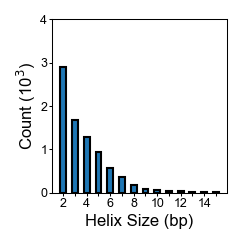

In [45]:
def get_helix_data(df):
    """Extract and process helix data from the main dataframe.

    Args:
        df: DataFrame containing motif data

    Returns:
        Series: Value counts of helix sizes up to 15 bp
    """
    helices = df.query("motif_type == 'Helix'").copy()
    helices["motif_topology"] = helices["motif_topology"].astype(int)
    helix_sizes = helices["motif_topology"].astype(int).value_counts()
    return helix_sizes[helix_sizes.index <= 15]  # Only keep sizes up to 15


def figure_b(df, ax):
    """Plot bar chart of helix size distribution.

    Args:
        df: DataFrame containing motif data
        ax: matplotlib axis to plot on
    """
    # Get helices and their sizes
    helix_sizes = get_helix_data(df)
    # Create bar plot of helix sizes
    ax.bar(helix_sizes.index, helix_sizes.values, edgecolor="black", width=0.5)
    ax.set_xlabel("Helix Size (bp)", labelpad=2)
    # Set x-ticks to show every other value and label every other bar
    ax.set_xticks(helix_sizes.index)
    labels = [str(x) if i % 2 == 0 else "" for i, x in enumerate(helix_sizes.index)]
    ax.set_xticklabels(labels, rotation=0, ha="center")
    ax.set_yticks([0, 1000, 2000, 3000, 4000])
    ax.set_yticklabels(["0", "1", "2", "3", "4"])

    ax.set_ylabel("Count (10$^3$)", labelpad=1)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=150)
figure_b(df, ax)

## Hairpin size distribution

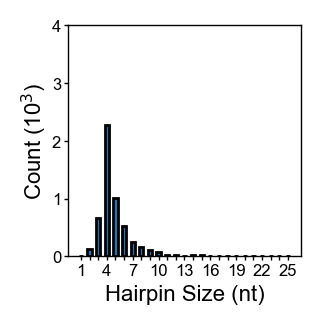

In [46]:
def get_hairpin_data(df):
    """Extract and process hairpin data from the main dataframe.

    Args:
        df: DataFrame containing motif data

    Returns:
        Series: Value counts of hairpin sizes up to 25 nt
    """
    hairpins = df.query("motif_type == 'Hairpin'").copy()
    hairpins["motif_topology"] = hairpins["motif_topology"].astype(int)
    hairpins = hairpins.query("motif_topology <= 25")
    hairpin_sizes = hairpins["motif_topology"].value_counts().sort_index()
    return hairpin_sizes


def figure_c(df, ax):
    """Plot bar chart of hairpin size distribution.

    Args:
        df: DataFrame containing motif data
        ax: matplotlib axis to plot on
    """
    # Get hairpins and their sizes
    hairpin_sizes = get_hairpin_data(df)

    # Create bar plot of hairpin sizes
    ax.bar(hairpin_sizes.index, hairpin_sizes.values, edgecolor="black", width=0.5)
    ax.set_xticks(hairpin_sizes.index)
    # Label every other bar
    labels = [str(x) if i % 3 == 0 else "" for i, x in enumerate(hairpin_sizes.index)]
    ax.set_xticklabels(labels, rotation=0)
    ax.set_yticks([0, 1000, 2000, 3000, 4000])
    ax.set_yticklabels(["0", "1", "2", "3", "4"])
    ax.set_ylabel("Count (10$^3$)", labelpad=1)
    ax.set_xlabel("Hairpin Size (nt)", labelpad=2)

    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=200)
figure_c(df, ax)

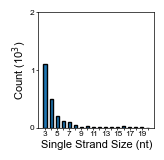

In [47]:
def get_single_strand_data(df):
    """Get single strand size distribution data.

    Args:
        df: DataFrame containing motif data

    Returns:
        Series: Value counts of single strand sizes up to 25 nt
    """
    singles = df.query("motif_type == 'Single Strand'").copy()
    singles["motif_topology"] = singles["motif_topology"].astype(int)
    singles = singles.query("motif_topology <= 20")
    single_sizes = singles["motif_topology"].value_counts().sort_index()
    return single_sizes


def figure_d(df, ax):
    """Plot bar chart of single strand size distribution.

    Args:
        df: DataFrame containing motif data
        ax: matplotlib axis to plot on
    """
    # Get single strands and their sizes
    single_sizes = get_single_strand_data(df)

    # Create bar plot of single strand sizes
    ax.bar(single_sizes.index, single_sizes.values, edgecolor="black", width=0.5)
    ax.set_xticks(single_sizes.index)
    ax.set_xlabel("Single Strand Size (nt)", labelpad=2)

    # Label every other bar
    labels = [str(x) if i % 2 == 0 else "" for i, x in enumerate(single_sizes.index)]
    ax.set_xticklabels(labels, rotation=0)
    ax.set_yticks([0, 1000, 2000])
    ax.set_yticklabels(["0", "1", "2"])

    ax.set_ylabel("Count (10$^3$)", labelpad=1)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(figsize=(1.5, 1.5))
figure_d(df, ax)

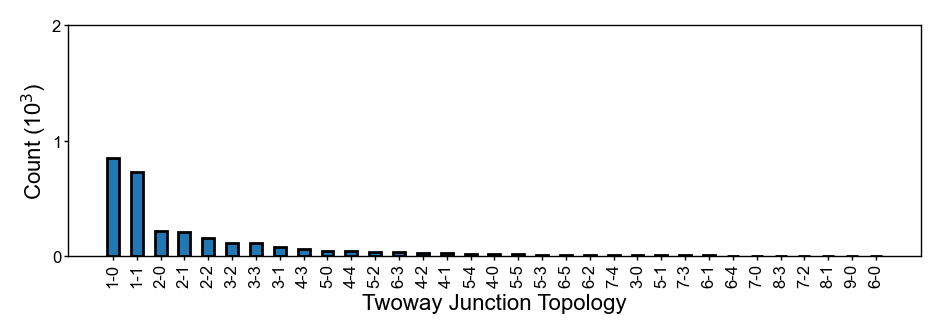

In [48]:
def get_twoway_data(df):
    """Get two-way junction data and their sizes.

    Args:
        df: DataFrame containing motif data

    Returns:
        Series containing two-way junction size counts
    """
    twoways = df.query("motif_type == 'Two-way'").copy()
    twoways = twoways.query("num_residues <= 15")
    twoway_sizes = twoways["motif_topology"].value_counts()
    return twoway_sizes


def figure_e(df, ax):
    """Plot bar chart of two-way junction size distribution.

    Args:
        df: DataFrame containing motif data
        ax: matplotlib axis to plot on
    """
    # Get two-way junctions and their sizes
    twoway_sizes = get_twoway_data(df)

    # Create bar plot of twoway sizes
    ax.bar(twoway_sizes.index, twoway_sizes.values, edgecolor="black", width=0.5)
    ax.set_xticks(twoway_sizes.index)
    ax.set_xlabel("Twoway Junction Topology", labelpad=2)

    # Label every bar
    labels = [str(x) for x in twoway_sizes.index]
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks([0, 1000, 2000])
    ax.set_yticklabels(["0", "1", "2"])

    # Remove tick marks
    ax.tick_params(axis="x", size=0)

    ax.set_ylabel("Count (10$^3$)", labelpad=1)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


# Create the plot
fig, ax = plt.subplots(figsize=(5.5, 1.5), dpi=200)
figure_e(df, ax)

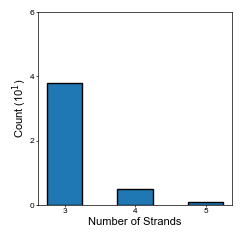

In [49]:
def get_nway_data(df):
    """Get N-way junction strand count data.

    Args:
        df: DataFrame containing motif data

    Returns:
        Series containing N-way junction strand counts
    """
    nways = df.query("motif_type == 'N-way'").copy()
    # Count number of strands by counting "-" in sequence and adding 1
    nways["num_strands"] = nways["motif_sequence"].str.count("-") + 1
    strand_counts = nways["num_strands"].value_counts().sort_index()
    return strand_counts


def figure_f(df, ax):
    """Plot bar chart of N-way junction strand count distribution.

    Args:
        df: DataFrame containing motif data
        ax: matplotlib axis to plot on
    """
    # Get N-way junctions and their strand counts
    strand_counts = get_nway_data(df)

    # Create bar plot of strand counts
    ax.bar(strand_counts.index, strand_counts.values, edgecolor="black", width=0.5)
    ax.set_xticks(strand_counts.index)
    ax.set_xlabel("Number of Strands", labelpad=2)

    # Label every bar since there will be fewer bars
    ax.set_xticklabels([str(x) for x in strand_counts.index], rotation=0)
    ax.set_ylabel("Count (10$^1$)", labelpad=1)
    ax.set_yticks([0, 20, 40, 60])
    ax.set_yticklabels(["0", "2", "4", "6"])
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


# Create the plot
fig, ax = plt.subplots(figsize=(2.5, 2.5))
figure_f(df, ax)

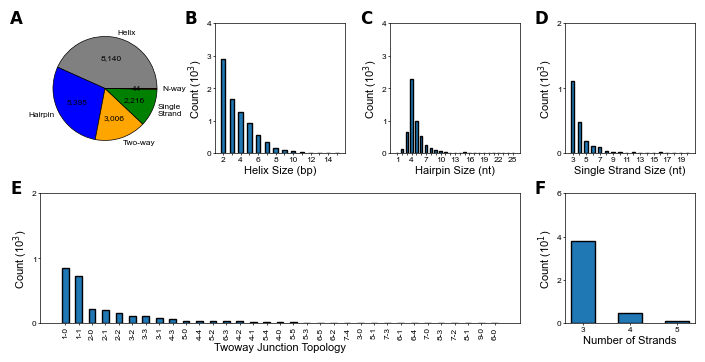

In [53]:
fig_size = (7, 4)
layout = (2, 4)
subplot_size = (1.3, 1.3)  # Each subplot is 4" x 3"
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.40,  # vertical spacing in inches
    "margins": {"left": 0.30, "right": 0.0, "top": 0.0, "bottom": 0.70},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)
# combine subplots 4, 5, and 6 into one subplot
coords_list = merge_sequential_coords(coords_list, 4, 6)

fig = plt.figure(figsize=(7, 4), dpi=100)

# Create subplots
ax1 = fig.add_axes(coords_list[0])
figure_a(df, ax1)

ax2 = fig.add_axes(coords_list[1])
figure_b(df, ax2)

ax3 = fig.add_axes(coords_list[2])
figure_c(df, ax3)

ax4 = fig.add_axes(coords_list[3])
figure_d(df, ax4)

ax5 = fig.add_axes(coords_list[4])
figure_e(df, ax5)

ax6 = fig.add_axes(coords_list[-1])
figure_f(df, ax6)


# add_text_inches(fig, fig_width, fig_height, 0.1, 0.1, "A", fontsize=12, weight="bold")
letters = ["A", "B", "C", "D", "E", "F"]
for i, letter in enumerate(letters):
    fig.text(
        coords_list[i][0] - 0.3 / fig_size[0],
        coords_list[i][1] + 1.3 / fig_size[1],
        letter,
        fontsize=12,
        weight="bold",
    )

fig.savefig(os.path.join(PLOT_PATH, "isolatable_motifs.png"), dpi=600)